In [1]:

import sys
from datetime import datetime
import time
import os

import pathlib
import pandas as pd
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0)) # CONUS
plot_proj = nwm_proj

## 
## READ IN jedi_letkf_out_obs_0000.nc FILES

In [2]:
%%time
def preprocess_jedi_out_obs(ds):
    path = ds.encoding['source']
    ds_list = list()
    ds_list.append(xr.open_dataset(path, group='MetaData'))
    for gg in ['ObsBias0','ObsBias1','ObsError','ObsValue','PreQC','hofx0_1','hofx0_2','hofx1_1','hofx1_2','hofx_y_mean_xb0','hofx_y_mean_xb1','oman','ombg']:
        ds_tmp = xr.open_dataset(path, group=gg).rename({'snow_water_equivalent': gg+'_SWE'})
        ds_list.append(ds_tmp)

    ds = xr.merge(ds_list)
    
    tt = ds.dateTime.values
    ttt = [datetime.strptime(str(t), "%Y-%m-%dT%H:%M:%S.000000000") for t in tt]
    date = ttt[0].date()
    # da = xr.DataArray(data=ttt, dims='ncols')
    # ds['ddd'] = da
    ds = ds.assign_coords(nlocs = ds.nlocs)
    ds = ds.expand_dims('date')
    
    # ds = ds.assign_coords({'datetime':("nlocs",ttt), 
    #                        'latitude':("nlocs",ds.latitude), 
    #                        'longitude':("nlocs",ds.longitude),
    #                        'height':("nlocs",ds.height),
    #                        'station_id':("nlocs", ds.station_id)})
    
    ds['date']=[np.datetime64(date)]
    return ds


files = sorted(glob.glob('jedi_wrfhydro_workflow-testcase-data-v1.0.3/swe_testcase/jedi_letkf_out_obs_swe*_0000.nc'))
ds = xr.open_mfdataset(files, preprocess=preprocess_jedi_out_obs) # open_mfdataset(files)
display(ds)


<xarray.Dataset>
Dimensions:              (nlocs: 5, date: 9)
Coordinates:
  * nlocs                (nlocs) int64 0 1 2 3 4
  * date                 (date) datetime64[ns] 2021-03-01 ... 2021-03-09
Data variables: (12/18)
    dateTime             (date, nlocs) datetime64[ns] 2021-03-01T10:00:00 ......
    height               (date, nlocs) float32 2.676e+03 2.652e+03 ... nan
    latitude             (date, nlocs) float32 40.8 40.85 41.07 ... 41.0 nan
    longitude            (date, nlocs) float32 -107.1 -107.0 ... -106.9 nan
    station_id           (date, nlocs) object 'EKDC2' 'ELKC2' ... 'WPKW4' nan
    ObsBias0_SWE         (date, nlocs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 nan
    ...                   ...
    hofx1_1_SWE          (date, nlocs) float32 140.4 138.6 292.5 ... 604.3 nan
    hofx1_2_SWE          (date, nlocs) float32 131.7 130.1 284.0 ... 595.8 nan
    hofx_y_mean_xb0_SWE  (date, nlocs) float32 47.09 24.9 168.4 ... 584.1 nan
    hofx_y_mean_xb1_SWE  (date, nlocs) float32 136.1 134.4 288.3 ... 600.1 nan
    oman_SWE             (date, nlocs) float32 184.0 206.0 217.2 ... 29.84 nan
    ombg_SWE             (date, nlocs) float32 272.9 315.5 337.1 ... 45.86 nan

CPU times: user 273 ms, sys: 28.8 ms, total: 302 ms
Wall time: 312 ms


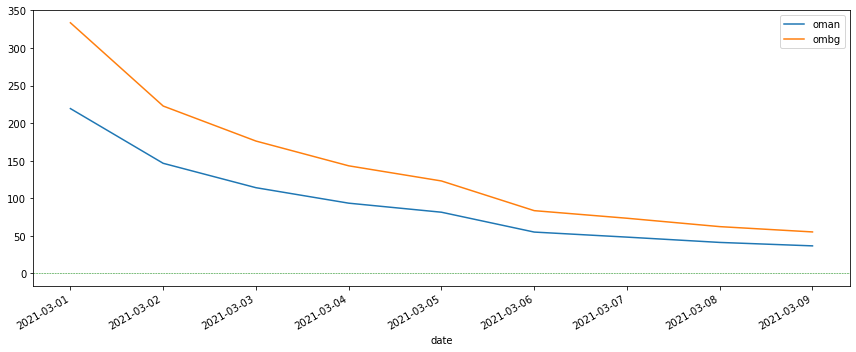

In [3]:

a = ds.oman_SWE.mean(dim='nlocs')
b = ds.ombg_SWE.mean(dim='nlocs')

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

a.plot(ax=axs, label='oman')
b.plot(ax=axs, label='ombg')
axs.axhline(y=0, color='green', linestyle='--', linewidth=0.5)
axs.legend()
axs.set_ylabel('')

plt.tight_layout()

- `ombg`: observation minus background
- `oman`: observation minus analysis

This plot evaluates the analysis phase of JEDI-DA. At each timestep, `oman` should be closer to zero (i.e., should have lower error values) comparing to `ombg`. Both lines should merge to the zero line after several applications of DA.

